This example is available as a jupyter notebook [here](https://github.com/SimiPixel/x_xy_v2/blob/main/docs/notebooks/knee_joint_translational_dof.ipynb).

And on Google Colab [here](https://colab.research.google.com/github/SimiPixel/x_xy_v2/blob/main/docs/notebooks/knee_joint_translational_dof.ipynb)

Setup the environment if this is executed on Google Colab.

*Make sure to change the runtime type to `GPU`. To do this go to `Runtime` -> `Change runtime type` -> `GPU`*

Otherwise, rendering won't work in Google Colab.

In [1]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.system("pip install --quiet 'x_xy[muj] @ git+https://github.com/SimiPixel/x_xy_v2'")
    os.system("pip install --quiet mediapy")

In [2]:
import x_xy
# automatically detects colab or not
x_xy.utils.setup_colab_env()

import jax
import jax.numpy as jnp

import mediapy as media

def show_video(sys, xs, **kwargs):
    media.show_video(x_xy.render(sys, [xs[i] for i in range(0, xs.shape(), 4)], camera="target", width=640, height=480, **kwargs), fps=25)

In [3]:
knee_xml_str = """
<x_xy model="knee_flexible_imus">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="femur" joint="free" pos="0.5 0.5 0.3" damping="5 5 5 25 25 25">
            <geom type="xyz" dim="0.1"/>
            <geom type="capsule" mass="1" euler="0 90 0" pos="0.2 0 0" dim="0.05 0.4"/>
            <body name="imu1" joint="frozen" pos="0.2 0 0.05" pos_min="0.05 0 0" pos_max="0.35 0 0">
                <geom type="xyz" dim="0.05"/>
                <geom type="box" mass="0.1" dim="0.05 0.05 0.02" color="orange"/>
            </body>
            <body name="tibia" joint="ry" pos="0.4 0 0" damping="3">
                <geom type="xyz" dim="0.1"/>
                <geom type="capsule" mass="1" euler="0 90 0" pos="0.2 0 0" dim="0.04 0.4"/>
                <body name="imu2" joint="frozen" pos="0.2 0 0.05" pos_min="0.05 0 0" pos_max="0.35 0 0">
                    <geom type="xyz" dim="0.05"/>
                    <geom type="box" mass="0.1" dim="0.05 0.05 0.02" color="orange"/>
                </body>
                <geom type="box" mass="0" pos="0.45 0 .1" dim="0.025 0.05 0.2"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

sys = x_xy.load_example(knee_xml_str)

Rendering frames..: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]



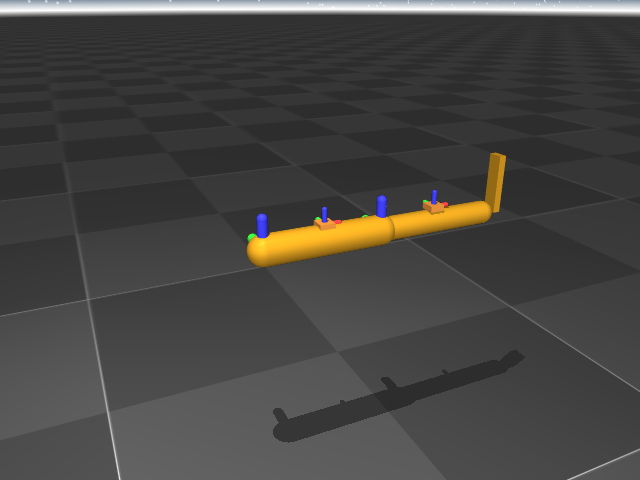

In [4]:
media.show_image(x_xy.render(sys, camera="target", height=480, width=640)[0])

In [5]:
T = 20.0
T_initial_nomotion = 2.0

config = x_xy.RCMG_Config(t_min=0.1, t_max=0.75, T=T, ang0_min=0.0, ang0_max=0.0, pos_min=-1.0, pos_max=1.0, dpos_max=0.5)
config = x_xy.concat_configs([config.to_nomotion_config(), config], [T_initial_nomotion])

(X, y), (_, qs, xs, sys_mod) = x_xy.build_generator(sys, config, imu_motion_artifacts=True, dynamic_simulation=True, eager=True, 
                                                    aslist=True, seed=1, sizes=1, keep_output_extras=True, imu_motion_artifacts_kwargs=dict(hide_injected_bodies=False))[0]

/Users/simon/Documents/PYTHON/x_xy_v2/x_xy/algorithms/generator/motion_artifacts.py:80: UserWarning: `sys.links.joint_params` has been set to zero, this might lead to unexpected behaviour unless you use `randomize_joint_params`
  warnings.warn(
/Users/simon/Documents/PYTHON/x_xy_v2/x_xy/algorithms/generator/base.py:162: UserWarning: `imu_motion_artifacts` is enabled but not `randomize_motion_artifacts`
  warnings.warn(
eager data generation: 1it [00:29, 29.62s/it]


In [6]:
show_video(sys_mod, xs, show_floor=False)

Rendering frames..: 100%|██████████| 500/500 [00:01<00:00, 302.73it/s]


In [7]:
sys_frozen = sys_mod.freeze("tibia").freeze("femur")

def freeze_x(q_obs):
    q_frozen = jnp.concatenate(tuple(q_obs[:, sys_mod.idx_map("q")[name]] for name in ["_imu1", "imu1", "_imu2", "imu2"]), axis=-1)
    return jax.vmap(lambda q: x_xy.algorithms.forward_kinematics_transforms(sys_frozen, q)[0])(q_frozen)

In [9]:
show_video(sys_frozen, freeze_x(qs))

Rendering frames..: 100%|██████████| 500/500 [00:02<00:00, 176.37it/s]
